In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:16px !important; }</style>"))

import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import rcParams
#rcParams['font.family'] = 'sans'
#rcParams['font.sans-serif'] = ['Tahoma']
rcParams['font.size'] = 22
#rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import emcee 
import corner
from astropy.io import fits 

Our goal for today is to fit some data. We are going to use physically motivated model to relate Stokes I and Stokes V and to obtain longitudinal magnetic field. Weak field approximation implies that: 

$$V = -4.69\times 10^-13 \frac{dI}{d\lambda}\lambda^2 g_L B_n $$

Where $g_L$ is the Lande factor of the line, $B_n$ is transversal magnetic field and $\lambda$ is the wavelength of the line. Since we are talking about a very small range of wavelenghts, we can use line center wavelenght here. Let's take some HINODE plage data and try to infer some magnetic fields ;-)

In [13]:
stokes = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")[0].data
print(stokes.shape)

(512, 873, 4, 112)


Text(0.5, 1.0, 'Continuum intensity map')

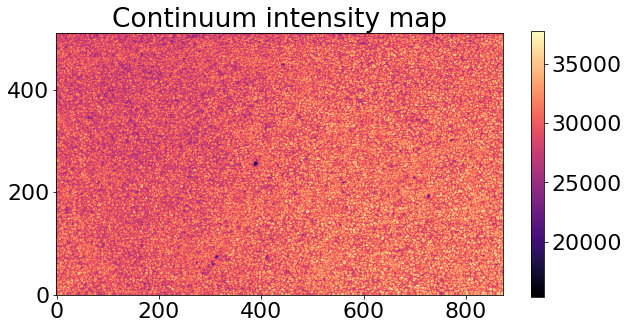

In [14]:
plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,0,0],origin='Lower',cmap='magma')
plt.colorbar(shrink=0.7)
plt.title("Continuum intensity map")

The next step is to figure out our wavelength grid. In principle we could do calibration but nice HINODE people already did that for us and there is a scale in the header of the individual files that I have used to assemble this. Let's take a look at that:

In [15]:
example = fits.open("/home/milic/data/Hinode_network/SP3D20120404_021106.1C.fits")
example[0].header

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                   16 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                  112 /                                                
NAXIS2  =                  512 /                                                
NAXIS3  =                    4 /                                                
EXTEND  =                    T /file may contain extensions                     
DATE    = '2012-04-09T15:31:41.000' /                                           
DATE_RF0= '2012-04-09T15:31:41.000' /                                           
TELESCOP= 'HINODE  '           /                                                
INSTRUME= 'SOT/SP  '           /                                                
MDP_CLK =        3519292774.00 /                                                
ORIGIN  = 'JAXA/ISAS, SIRIUS

CRPIX1  =              56.5000 /                                                
CRVAL1  =              6302.08 / 

These two lines are telling us that pixel "number" 56.5 has wavelenght of 6302.08 Angstroms. Sampling is 0.0215 Angstroms per pixel. (Wrongly quoted as "resolution" here): 

https://hesperia.gsfc.nasa.gov/ssw/hinode/sot/doc/guide/SAGv3.3.pdf

In [16]:
# So, to make wavelength, let's do something like this. 
NL = 112 
ll = np.linspace(0,NL-1,NL)
ll = 6302.08 + (ll-56.5)*0.0215
print (ll)

[6300.86525 6300.88675 6300.90825 6300.92975 6300.95125 6300.97275
 6300.99425 6301.01575 6301.03725 6301.05875 6301.08025 6301.10175
 6301.12325 6301.14475 6301.16625 6301.18775 6301.20925 6301.23075
 6301.25225 6301.27375 6301.29525 6301.31675 6301.33825 6301.35975
 6301.38125 6301.40275 6301.42425 6301.44575 6301.46725 6301.48875
 6301.51025 6301.53175 6301.55325 6301.57475 6301.59625 6301.61775
 6301.63925 6301.66075 6301.68225 6301.70375 6301.72525 6301.74675
 6301.76825 6301.78975 6301.81125 6301.83275 6301.85425 6301.87575
 6301.89725 6301.91875 6301.94025 6301.96175 6301.98325 6302.00475
 6302.02625 6302.04775 6302.06925 6302.09075 6302.11225 6302.13375
 6302.15525 6302.17675 6302.19825 6302.21975 6302.24125 6302.26275
 6302.28425 6302.30575 6302.32725 6302.34875 6302.37025 6302.39175
 6302.41325 6302.43475 6302.45625 6302.47775 6302.49925 6302.52075
 6302.54225 6302.56375 6302.58525 6302.60675 6302.62825 6302.64975
 6302.67125 6302.69275 6302.71425 6302.73575 6302.75725 6302.7

Now, it would be good to take a look at the whole spectrum to see where we expect the peak of the polarization, because we want to take a look at Stokes V map

Text(0, 0.5, 'Stokes I')

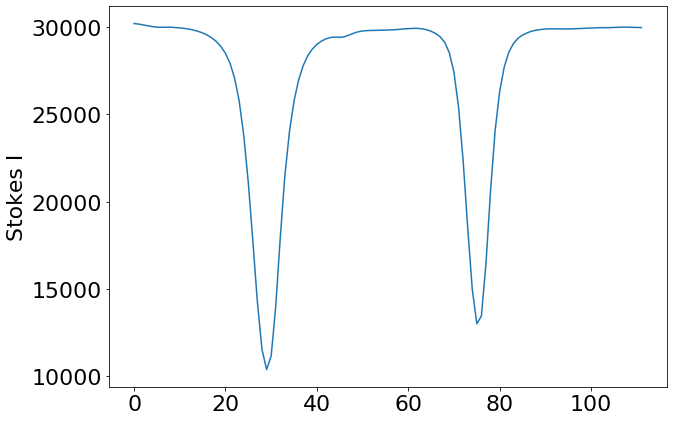

In [18]:
mean = np.mean(stokes,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(mean[0])
plt.ylabel("Stokes I")

Text(0.5, 1.0, 'Stokes V in the blue wing of 6301.5')

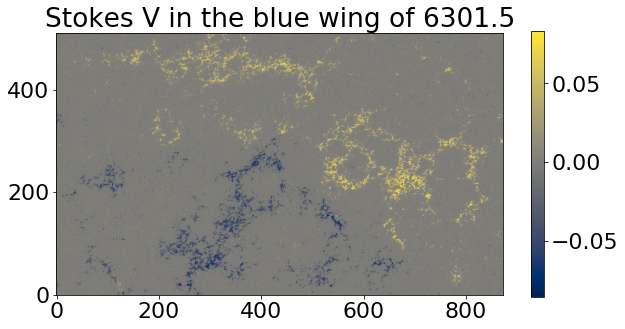

In [21]:
#Looks like we can take ~ index 23 or so for the blue wing of 6301.5 line

plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,3,23]/mean[0,0],origin='Lower',cmap='cividis')
plt.colorbar(shrink=0.7)
plt.title("Stokes V in the blue wing of 6301.5")

Looks like the point with index ~ (250,700) (remember Python plots reverse Axes)

Let's plot Stokes I and V

Text(0, 0.5, 'Stokes $V$')

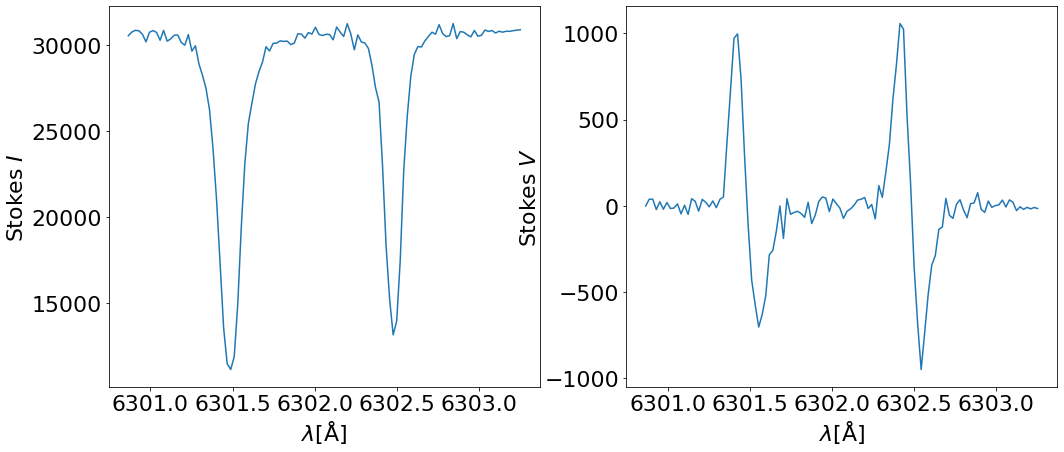

In [22]:
i = 250
j = 700

plt.figure(figsize=[17,7])
plt.subplot(121)
plt.plot(ll,stokes[i,j,0])
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("Stokes $I$")
plt.subplot(122)
plt.plot(ll,stokes[i,j,3])
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("Stokes $V$")

Wow the shape of the Stokes V really does look like the shape of the derivative of the Stokes I. Let's check that. 

Text(0, 0.5, 'Stokes $V$')

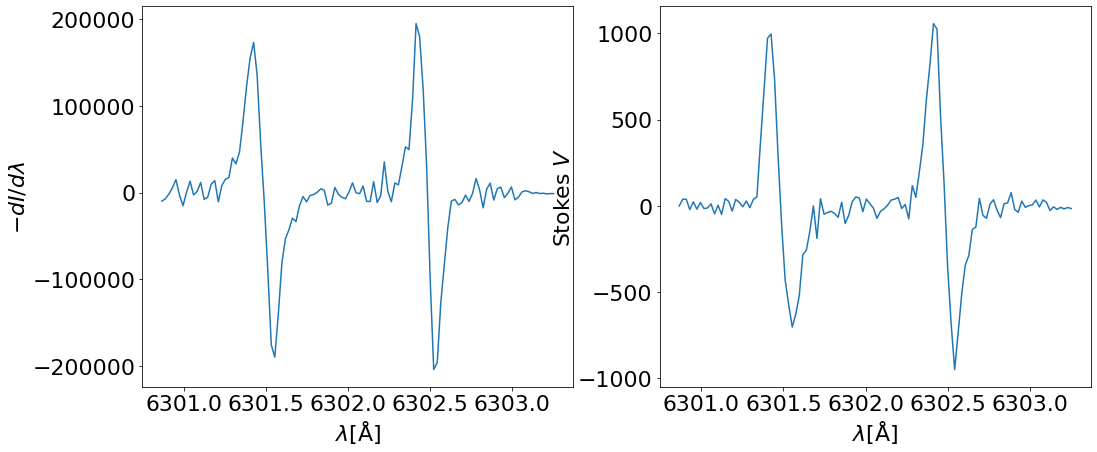

In [25]:
i = 250
j = 700

#There is a built in function called gradient that does this. Remember that V ~ -dI/dlambda
dI_dl = np.gradient(stokes[i,j,0])/np.gradient(ll)

plt.figure(figsize=[17,7])
plt.subplot(121)
plt.plot(ll,-dI_dl)
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("$-dI/d\\lambda$")
plt.subplot(122)
plt.plot(ll,stokes[i,j,3])
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("Stokes $V$")

Now next step is to calculate the magnetic field from this. As we said V is directly propotional to $dI/d\lambda$. So I can fit V to $dI/d\lambda$!!!! For starters using just matrix inversion. Note that we have to treat the two lines separately as they have different lande factors. 

Text(0, 0.5, 'V')

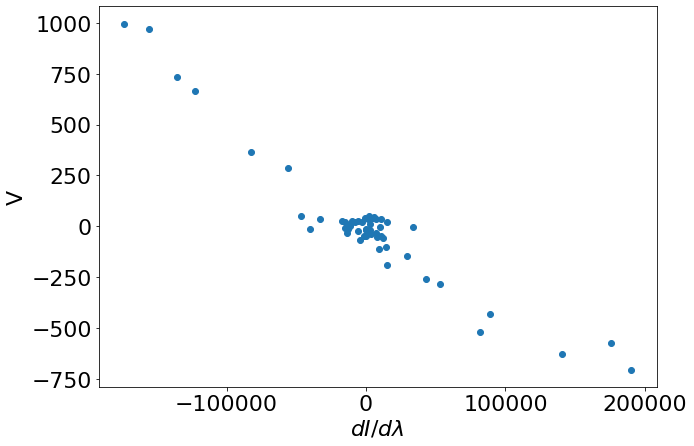

In [37]:
# Let's do a plot:
plt.figure(figsize=[10,7])
plt.plot(dI_dl[:56],stokes[i,j,3,:56],'o')
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

We want to fit this with a linear function now, that is basically something like this:
$$k x +n =y $$
Or written as a matrix equation, keep in mind $k$ and $n$ are unknowns...
$$(\vec{x} , \vec{1})(k,n)^T = y$$ 

In [38]:
#Let's do the fit
# number of data
ND = 56
a = np.zeros([ND,2])
a[:,0] = dI_dl[:ND]
a[:,1] = 1.0
b = stokes[i,j,3,:ND]
a_inv = np.linalg.pinv(a)
p = np.linalg.inv((a_inv @ a))@ (a_inv @ b)
print (p)

[-0.00465178  2.74171585]


Let's see if this makes sense

Text(0, 0.5, 'V')

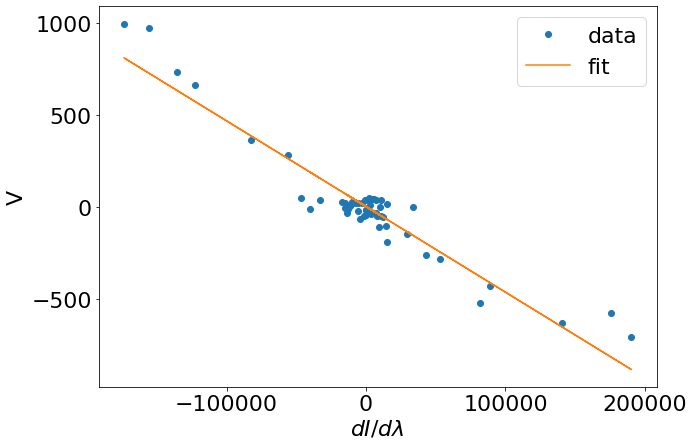

In [39]:
plt.figure(figsize=[10,7])
plt.plot(dI_dl[:56],stokes[i,j,3,:56],'o',label='data')
plt.plot(dI_dl[:56],dI_dl[:56]*p[0]+p[1],label='fit')
plt.legend()
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

Now let's estimate the magnetic field from this. Remember that $k = - 4.69\times 10^{-13} \times B\lambda_0^2 g_l$

In [43]:
B = -p[0] / 4.69E-13 / 6301.5**2.0 / 1.5
print (B)

166.52029656938768


Now you can take some time and try out if you get the same result with the second line!

In [44]:
#.......... here we spend some time re-running this for the second line

Now a good question is ... what are our measurement uncertainties!!!! Ok, let's learn that MCMC. For that we will need to explicitly define our likelyhood, prior and posterior. Let's do that. 

In [50]:
#Likelyhood, depends on the function parameters (that can change) and the observations (that are fixed). For convenience we will work
# in log scale

def ln_like(params, x, y, error):
    
    y_model = params[0] * x + params[1]
    chi2 = ((y_model - y) / error)**2
    return np.sum(-0.5 * chi2)# - 0.5*np.log(2*np.pi) - np.log(y)) # I am making it depend on errors in purpose

def ln_prior(params):
    # all parameters equally likely
    return 0.

def ln_post(params, x, y, error):
    lnprior_val = ln_prior(params)
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, x, y, error)
        return lnprior_val + lnlike_val

So now we are sampling. What are we sampling? The posterior, rright! 

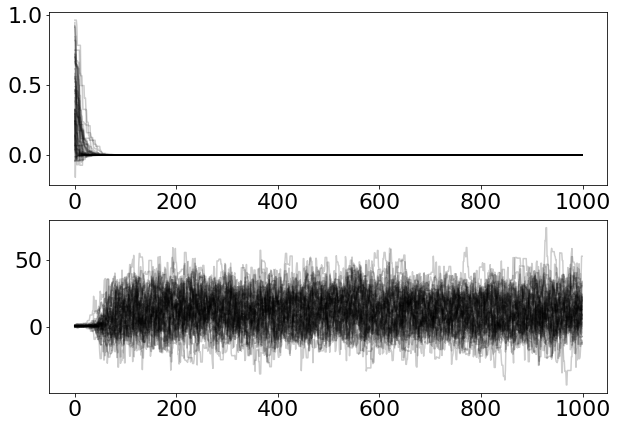

In [57]:
ndim = 2 # because we have two parameters 
nwalkers = 50 # this is number of random points
x_data = dI_dl[:56]
y_data = stokes[i,j,3,:56]
errors = np.zeros(56)
errors[:] = 100.

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[x_data,y_data,errors])

num_steps = 1000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)
plt.figure(figsize=[10,7])
plt.subplot(211)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2)
plt.subplot(212)
plt.plot(sampler.chain[:, :, 1].T, '-k', alpha=0.2)

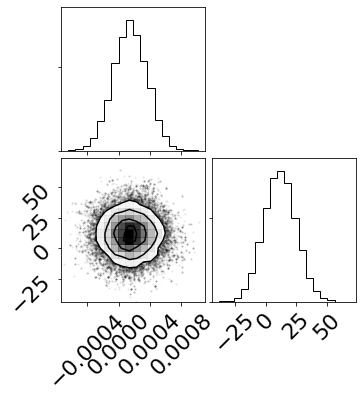

In [59]:
figure = corner.corner(sampler.flatchain[5000:])